In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.svm import SVC,LinearSVC
import matplotlib.pyplot as plt
import os
import copy
import configparser
import joblib
import time

In [2]:
cwd = os.getcwd()
os.chdir('..')
from scripts.features import get_features
os.chdir(cwd)

In [3]:
def get_index(data_num):
    config = configparser.ConfigParser()
    config_path = os.path.join(os.getcwd(), '../', 'config.ini')
    config.read(config_path)
    acc_path = config.get('Paths', 'acc_data_directory')
    acc_data_path = os.path.join(os.getcwd(), '../', acc_path)
    files = os.listdir(acc_data_path)
    file_idx = -1
    for idx in range(len(files)):
        if files[idx][7] == str(data_num):
            file_idx = idx
            break
    return file_idx

In [4]:
def get_training_df(date, data_nums, features=['z_rms', 'Velocity'], model_type='roughness'):
    all_training_df = pd.DataFrame()
    for data_num in data_nums:
        label_path = os.path.join(os.getcwd(), '../data/labels/'+date+'/'+'auto_'+str(data_num)+'_labels.csv')
        label_data = pd.read_csv(label_path)
        acc_path = os.path.join(os.getcwd(), '../data/acc/'+date+'/pickledData/pickled'+str(data_num)+'.pkl')
        acc_data = pd.read_pickle(acc_path)
        if 'accTime' not in acc_data:
            acc_data.rename(columns = {'Time': 'accTime'}, inplace = True) 
        if label_data['Time'].dtype != float:
            from datetime import datetime
            lab_time = label_data['Time']
            lab_time = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S:%f') for x in lab_time]
            lab_time = pd.Series(lab_time)
            lab_time = lab_time.apply(lambda x: x.timestamp()) 
        if acc_data['accTime'].dtype != float:
            print("#########")
            time_ = acc_data['accTime']
            time_ = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S:%f') for x in time_]
            time_ = pd.Series(time_)
            time_ = time_.apply(lambda x: x.timestamp())
            lab_time = lab_time - time_[0]
            label_data['Time'] = lab_time
        else:
            label_data['Time'] = lab_time - lab_time[0]
        data_index = get_index(data_num)
        cur_training_df = get_features(data_index, features = features, training=True, label_df=label_data, model_type=model_type)
        if not cur_training_df.empty:
            all_training_df = pd.concat([all_training_df, cur_training_df])
        all_training_df = all_training_df.reset_index(drop=True)
    return all_training_df

In [5]:
date = '29March2024'
data_nums = [1, 2, 3, 4, 5, 8]
model_type='roughness'
DEBUG=False

In [6]:
# features = ['z_rms', 'Velocity']
# features = ['z_variance', 'Velocity']
# features = ['z_variance', 'z_rms', 'Velocity']
features = ['z_p2p', 'z_tpah', 'z_variance', 'z_rms', 'Velocity']

In [7]:
start = time.process_time()
training_df = get_training_df(date, data_nums, model_type=model_type, features=features)
print("Total time taken for training data of size", len(training_df), "is: ", round(time.process_time()-start, 5))
if DEBUG:
    print(training_df)

Individual time taken by creating slinding windows: 0.00193 seconds for data size: 4142
Individual time taken by creating slinding windows: 0.0023 seconds for data size: 5555
Individual time taken by creating slinding windows: 0.00292 seconds for data size: 16835
Individual time taken by creating slinding windows: 0.00233 seconds for data size: 9300
Individual time taken by creating slinding windows: 0.00166 seconds for data size: 2484
Individual time taken by creating slinding windows: 0.00304 seconds for data size: 15783
Total time taken for training data of size 1022 is:  2.34963


In [8]:
if DEBUG:
    x = np.linspace(0, len(training_df), len(training_df))
    plt.plot(x,
             training_df['z_rms'],
             label = 'rms', color='r', alpha=0.8)
    
    plt.plot(x,
             training_df['Velocity'],
             label = 'Velocity', color='b')
    
    plt.plot(x,
             training_df['Label'],
             label = 'label', color='g', linewidth=3)
    
    plt.plot(x,
             training_df['z_variance'],
             label = 'Variance', color='orange')
    
    plt.plot(x,
             training_df['z_p2p'],
             label = 'p2p', color='black')

    plt.plot(x,
             training_df['z_tpah'],
             label = 'tpah', color='yellow')
    
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
def plot_actual_vs_predicted(Y_actual, Y_pred):
    x = np.linspace(0, len(Y_actual), len(Y_actual))
    plt.figure(figsize=(12,5))
    plt.plot(x, Y_actual, color='g', label='actual')
    plt.plot(x, Y_pred, color='r', label='predicted')
    plt.title('ACTUAL VS PREDICTED LABELS')
    plt.grid()
    plt.legend()
    plt.show()

In [120]:
# input_features = ['Velocity'] #Best - Test 90 | Total 94
input_features = ['z_rms', 'Velocity'] # - Test 77 | Total 93
# input_features = ['z_variance', 'Velocity'] # - Test 76 | Total 92
# input_features = ['z_variance', 'z_rms', 'Velocity'] # - Test 72 | Total 92
# input_features = ['z_p2p', 'Velocity'] # Test 77 | Total 90
# input_features = ['z_tpah', 'Velocity'] # Test 76 | Total 92
# input_features = ['z_p2p', 'z_tpah', 'Velocity'] # Worst - Test 67 | Total 72
# input_features = ['z_rms', 'z_variance', 'z_tpah', 'Velocity'] # Test 74 | Total 92
# input_features = ['z_rms', 'z_variance', 'z_p2p', 'Velocity'] # Test 70 | Total 79
# input_features = ['z_rms', 'z_p2p', 'Velocity'] # Test 73 | Total 92
# input_features = ['z_rms', 'z_variance', 'z_tpah', 'z_p2p', 'Velocity'] # Test 71 | Total 88
X = training_df[input_features]
Y = training_df['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

######## creating a random forest classifier ########
# rndm_clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
# rndm_clf.fit(X_train, Y_train)

In [121]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)
rand_search.fit(X_train, Y_train)
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 409}


In [122]:
Y_pred = best_rf.predict(X_test) #rndm_clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f'models accuracy on test data is: {accuracy}')

Y_pred_comp = best_rf.predict(X) #rndm_clf.predict(X)
accuracy = accuracy_score(Y, Y_pred_comp)
print(f'models accuracy on complete data is: {accuracy}')

models accuracy on test data is: 0.7654723127035831
models accuracy on complete data is: 0.9295499021526419


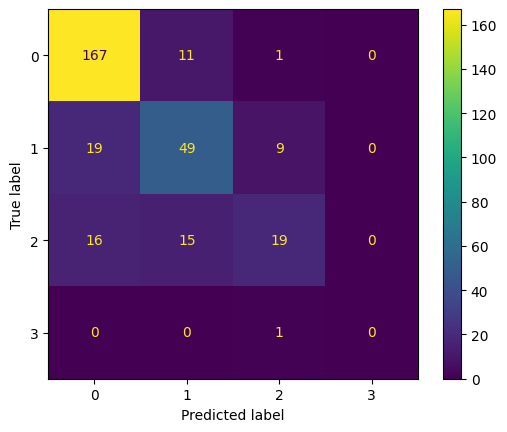

In [123]:
# Y_pred = best_rf.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

FEATURE IMPORTANCE


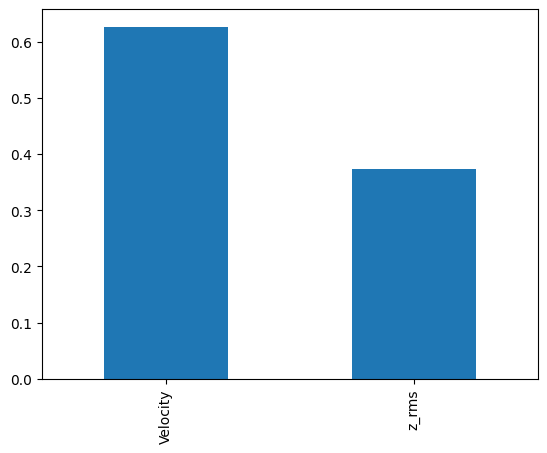

In [124]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();
print("FEATURE IMPORTANCE")

Test Accuracy: 76.55
Overall Accuracy: 92.95


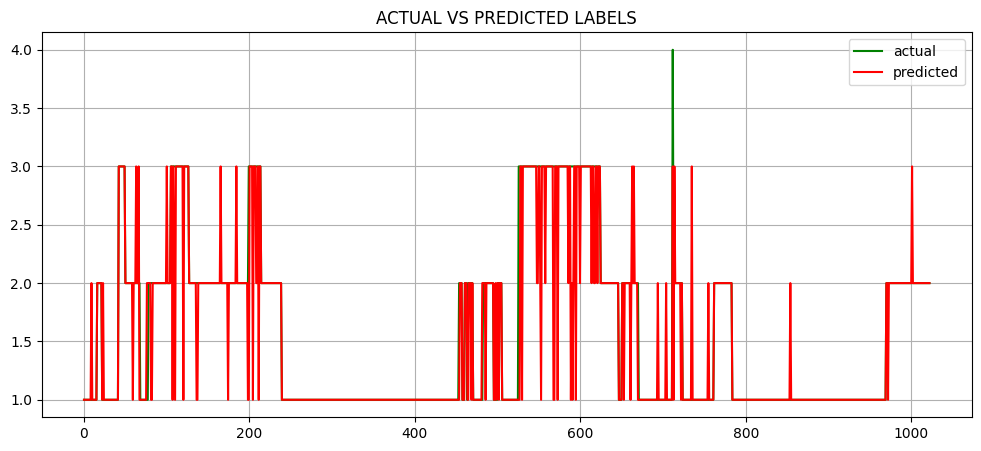

In [125]:
print("Test Accuracy:", round(accuracy_score(Y_test, Y_pred)*100, 2))
print("Overall Accuracy:", round(accuracy_score(Y, Y_pred_comp)*100, 2))
plot_actual_vs_predicted(Y, Y_pred_comp)

In [126]:
#save rndm_clf as a pickle file
joblib.dump(best_rf, '../models/rf_roughness.pkl')

['../models/rf_roughness.pkl']